# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1ucApqnMP7FwscKX1wRMTfhTon_wsUDWO

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

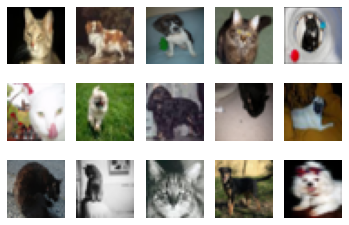

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
# Find individual cat and dog classes for every example
cat_train, cat_test, cat_validate = 0, 0, 0
dog_train, dog_test, dog_validate = 0, 0, 0

for images, labels in train_loader:
  for label in labels:
    if label == 5:
      dog_train = dog_train + 1
    elif label == 3:
      cat_train = cat_train + 1

for images, labels in test_loader:
  for label in labels:
    if label == 5:
      dog_test = dog_test + 1
    elif label == 3:
      cat_test = cat_test + 1

for images, labels in val_loader:
  for label in labels:
    if label == 5:
      dog_validate = dog_validate + 1
    elif label == 3:
      cat_validate = cat_validate + 1

# The number of training cat and dog examples
print("The number of training examples for the cat classes is: " + str(cat_train))
print("The number of training examples for the dog classes is: " + str(dog_train))

# The number of validation cat and dog examples
print("The number of validation examples for the cat classes is: " + str(cat_validate))
print("The number of validation examples for the dog classes is: " + str(dog_validate))

# The number of test cat and dog examples
print("The number of test examples for the cat classes is: " + str(cat_test))
print("The number of test examples for the dog classes is: " + str(dog_test))

# The number of training examples
print("The number of training examples for the combined cat and dog classes is: " + str(len(train_loader)))
# The number of validation examples
print("The number of validation examples for the combined cat and dog classes is: " + str(len(val_loader)))
# The number of test examples
print("The number of validation examples for the combined cat and dog classes is: " + str(len(test_loader)))


The number of training examples for the cat classes is: 4018
The number of training examples for the dog classes is: 3982
The number of validation examples for the cat classes is: 982
The number of validation examples for the dog classes is: 1018
The number of test examples for the cat classes is: 1000
The number of test examples for the dog classes is: 1000
The number of training examples for the combined cat and dog classes is: 8000
The number of validation examples for the combined cat and dog classes is: 2000
The number of validation examples for the combined cat and dog classes is: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

The validation set is needed to judge the performance of our models. The validation set is new data as opposed to the training set which is used to train the data. Thus, we're able to test our model more, and tune
the hyperparameters to get more optimal results. We can also ensure that the model isn't overfitted or underfitted to the training set with the performance we obtain from the validation set. Judging the performance of our models using the training set instead of the validation set doesn't give us an accurate representation of how our model is actually performing. In reality, our model could have a training set loss/error of 0, which implies that our model is perfect, but this could just mean that our model is just memorizing the training set instead of finding patterns within the data. All of these concerns can be debunked when testing the model on the validation set.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
small_parameters = 0
large_parameters = 0

# Small net parameters
for param in small_net.parameters():
  print(param.shape)
  temp = 1
  for x in param.shape:
    temp = temp * x
  small_parameters = small_parameters + temp 

print("The total number of parameters in small_net are: " + str(small_parameters))

print("\n")

# Large net parameters
for param in large_net.parameters():
  print(param.shape)
  temp = 1
  for x in param.shape:
    temp = temp * x
  large_parameters = large_parameters + temp

print("The total number of parameters in large_net are: " + str(large_parameters))

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
The total number of parameters in small_net are: 386


torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
The total number of parameters in large_net are: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

The default value of the batch_size is 64.
The default value of the learning_rate is 0.01.
The default value of the num_epochs is 30.



### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431, Train loss: 0.674514232635498 |Validation err: 0.3765, Validation loss: 0.6565842255949974
Epoch 2: Train err: 0.368625, Train loss: 0.6483634223937988 |Validation err: 0.3895, Validation loss: 0.6615555267781019
Epoch 3: Train err: 0.349375, Train loss: 0.6327687554359436 |Validation err: 0.3535, Validation loss: 0.6234166659414768
Epoch 4: Train err: 0.334125, Train loss: 0.6138443050384521 |Validation err: 0.357, Validation loss: 0.6245265696197748
Epoch 5: Train err: 0.322, Train loss: 0.6009030966758728 |Validation err: 0.3315, Validation loss: 0.6150128208100796
Finished Training
Total time elapsed: 23.89 seconds



*   5 model checkpoints are saved after the completion of each epoch
*   A file with the model's training set error values after each epoch will be saved
*   A file with the model's validation set error values after each epoch will be saved
*   A file with the model's training set loss values after each epoch will be saved
*   A file with the model's validation set loss values after each epoch will be saved



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.313125, Train loss: 0.5911787014007568 |Validation err: 0.3385, Validation loss: 0.6125897411257029
Epoch 2: Train err: 0.306625, Train loss: 0.5853038504123688 |Validation err: 0.3345, Validation loss: 0.6116138435900211
Epoch 3: Train err: 0.30675, Train loss: 0.5847535398006439 |Validation err: 0.3385, Validation loss: 0.6066650105640292
Epoch 4: Train err: 0.305625, Train loss: 0.5810915820598602 |Validation err: 0.336, Validation loss: 0.6093359375372529
Epoch 5: Train err: 0.301, Train loss: 0.5751889472007752 |Validation err: 0.325, Validation loss: 0.6063608080148697
Epoch 6: Train err: 0.296375, Train loss: 0.5714125916957855 |Validation err: 0.3385, Validation loss: 0.6082403678447008
Epoch 7: Train err: 0.297125, Train loss: 0.5700898551940918 |Validation err: 0.3265, Validation loss: 0.5942695746198297
Epoch 8: Train err: 0.29, Train loss: 0.5664230802059174 |Validation err: 0.

The small net training took 145.43 seconds and the large net training took 154.19 seconds. The large net training took longer because it has an additonal layer and more paramaters which need to be updated during training.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small Network: 


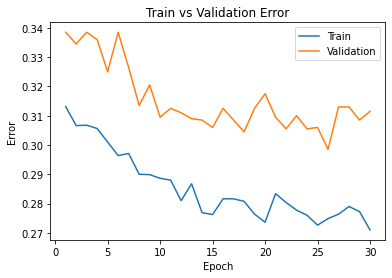

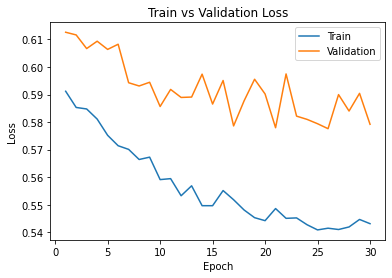

Large Network: 


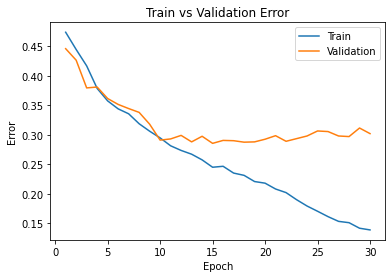

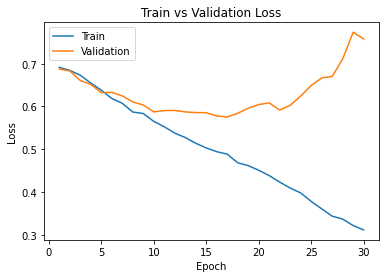

In [ ]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
print("Small Network: ")
plot_training_curve(small_model_path)

large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("Large Network: ")
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

One consistency I see with the training curve for errors and losses for both the small_net and large_net is that it is consistently decreasing as we increase the number of epochs. This is an indication that the parameters are being fine tuned in order to give us more accurate results. Although, it is notable that for the validation set in the large_net, it begins to plateau after 5 epochs. For the large_net, after 20 epochs, the validation set actually begins to increase; this is an indication of overfitting - the model memorizes the training set data too well and doesn't find patterns, so when it's tasked with classifying new data, it doesn't give accurate results as expected.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

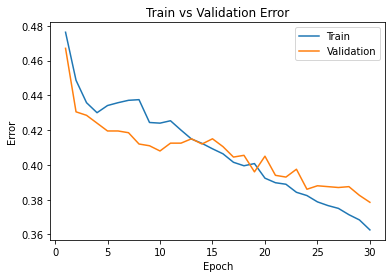

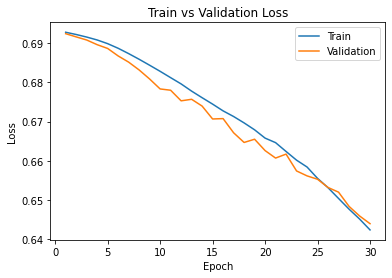

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
plot_training_curve(get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29))

The large_net training with 0.01 learning rate took 154.19 seconds. The large_net training with 0.001 learning rate took 154.88 seconds. These training times are both similar.
Some effects of lowering the learning rate are: the validation and training set curves for loss and error are almost identical if the learning rate is lower. The overfitting that we observed with the larger learning rate is avoided here. The loss and error values are overall higher with the lower learning late. As the validation curve is lower than the training curve for both loss and error with the lower learning rate, it might be slightly underfitted.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

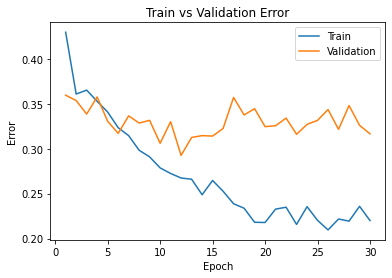

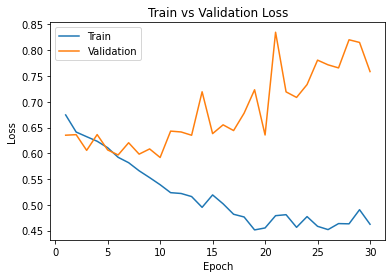

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

The large net with a lower learning rate took 150.96 seconds and the large net with default paramaters took 154.19 seconds. The times for both are similar. Some effects of increasing the learning rate are: fluctuation in both loss and error curves for train and validation as compared to a lower learning rate, an overfitted model with the number of epochs increasing, an exponential decrease in training error and loss, and an increase in validation loss as number of epochs are increasing.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

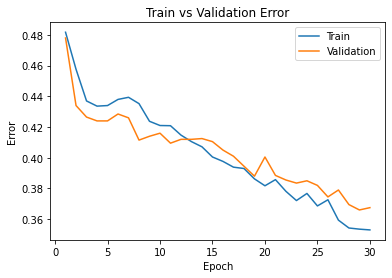

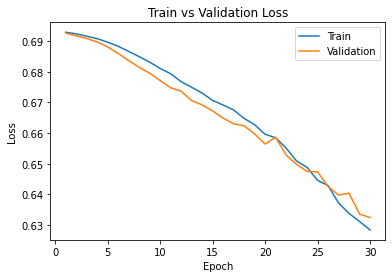

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

The large net with a batch size of 512 took 137.11 seconds and the large net with default paramaters took 154.19 seconds. The higher batch size training time was quicker. This is because there is less iteration that takes place per epoch. The effects of increasing the bath size are: smoother training and validation curves, more time to decrease loss curves for training and validation data, steady decrease for training and validation curves as the number of epochs increases.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

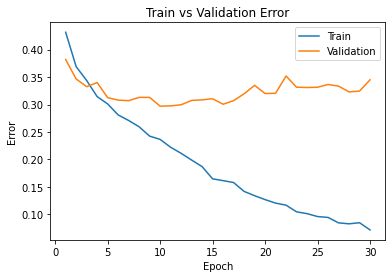

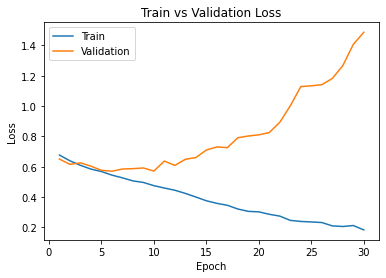

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

The large net with a batch size of 16 took 215.88 seconds. The large net with default paramaters took 154.19 seconds. The large net with a smaller batch size took longer to train. This is because there are more iterations that take place per epoch. The effects of lowering the batch size are: low training loss and error, overfitting for validation curve for both loss and error - for error, the validation plateaurs whereas it consistently increases for loss as we increase the number of epochs. The validation curves in general are very poor in comparison with the training curves.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I would choose the following hyperparameters:

1. Large Network

    * Validation and training curves for loss and error fluctuate less than the small net 

2. Batch size = 512

    * There was no overfitting observerd
    * The loss and error curves for both validation and training decrease steadily as we increase the number of epochs

3. Epochs = 40

    *   There was no overfitting observerd

4. Learning rate = 0.001

    * There was no overfitting observerd
    * The loss and error curves for both validation and training decrease steadily as we increase the number of epochs

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

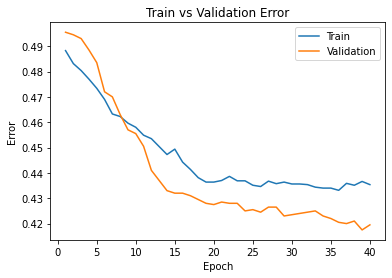

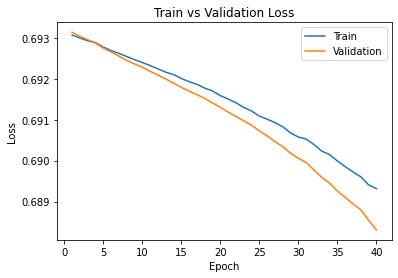

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size= 512, learning_rate= 0.001, num_epochs=40)
large_model_path = get_model_name("large", batch_size= 512, learning_rate= 0.001, epoch=39)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

Based on my result from Part(a), I notice that my training and validation error curves are both plateau until 20 epochs and then they rapidly decrease. My hyperparameters chosen generally overfit the data as the loss and error are higher than I'd want them to be. I want to try increasing the number of epochs as that would give us more iterations, keep the large network, and increase the learning rate while decreasing the batch size.

Hyperparameters chosen:
Batch size = 256, learning rate = 0.005, epochs = 75, large network.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6929918043315411 |Validation err: 0.4895, Validation loss: 0.6920944899320602
Epoch 2: Train err: 0.48725, Train loss: 0.6922785621136427 |Validation err: 0.4675, Validation loss: 0.6913378164172173
Epoch 3: Train err: 0.453125, Train loss: 0.6915246844291687 |Validation err: 0.434, Validation loss: 0.6904729753732681
Epoch 4: Train err: 0.45225, Train loss: 0.690559322014451 |Validation err: 0.432, Validation loss: 0.6892406046390533
Epoch 5: Train err: 0.448375, Train loss: 0.6895249728113413 |Validation err: 0.432, Validation loss: 0.6878118962049484
Epoch 6: Train err: 0.448125, Train loss: 0.6886843405663967 |Validation err: 0.428, Validation loss: 0.6861879155039787
Epoch 7: Train err: 0.44375, Train loss: 0.687343480065465 |Validation err: 0.431, Validation loss: 0.6845433935523033
Epoch 8: Train err: 0.443125, Train loss: 0.6859446428716183 |Validation err: 0.4

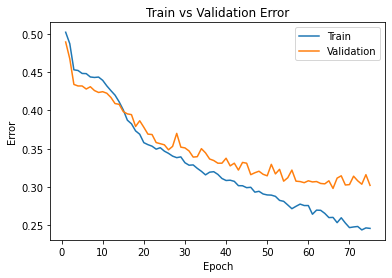

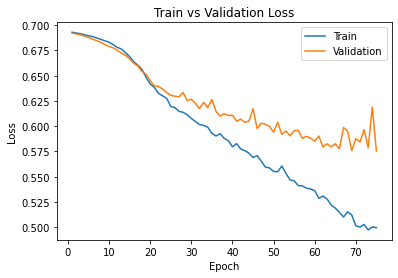

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size= 256, learning_rate= 0.005, num_epochs=75)
large_model_path = get_model_name("large", batch_size= 256, learning_rate= 0.005, epoch=74)
plot_training_curve(large_model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
train_net(net, batch_size= 256, learning_rate= 0.005, num_epochs=75)
large_model_path = get_model_name("large", batch_size= 256, learning_rate= 0.005, epoch=74)
state = torch.load(large_model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.695561446249485 |Validation err: 0.491, Validation loss: 0.6922401264309883
Epoch 2: Train err: 0.496125, Train loss: 0.6924937833100557 |Validation err: 0.46, Validation loss: 0.6913722455501556
Epoch 3: Train err: 0.45675, Train loss: 0.6913368869572878 |Validation err: 0.4425, Validation loss: 0.6907863020896912
Epoch 4: Train err: 0.45325, Train loss: 0.6902701798826456 |Validation err: 0.428, Validation loss: 0.6896535903215408
Epoch 5: Train err: 0.43525, Train loss: 0.6889143753796816 |Validation err: 0.42, Validation loss: 0.6878968328237534
Epoch 6: Train err: 0.435125, Train loss: 0.6874378751963377 |Validation err: 0.422, Validation loss: 0.6855512335896492
Epoch 7: Train err: 0.42925, Train loss: 0.6850125286728144 |Validation err: 0.424, Validation loss: 0.6824621260166168
Epoch 8: Train err: 0.42575, Train loss: 0.6820058375597 |Validation err: 0.407, Val

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

These are the reasons why the following hyperparameters performed the best:

1. Large Network

    * Validation and training curves for loss and error fluctuate less than the small net 

2. Batch size = 256

    * The loss and error curves for both validation and training decrease steadily as we increase the number of epochs
    * A large batch size doesn't predict validation data well (generalizes the training data) but a low one doesn't give us the best validation accuracy.

3. Epochs = 75

    *   There was no overfitting observerd
    *   There was converging for the validation data at the loss curve. The slope was about to plateau for a high number of epochs, which indicates neither overfitting or underfitting

4. Learning rate = 0.005

    * There was no overfitting observerd
    * The loss and error curves for both validation and training decrease steadily as we increase the number of epochs


### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

test_err, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("The error on the test set is: ", test_err)
print("The loss on the test set is: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
The error on the test set is:  0.279
The loss on the test set is:  0.5362545400857925


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The validation error is approximtely 29% and the test error is approximately 28%. We would usually expect the test error to be higher than the validation error because the model is not being tuned with hyperparameters during the validation set stage. However, test data is completely new data irrespective of hyperparamater tuning and model adjustments. Thus, test data accuracy is not being fine tuned when the model looks at it. This is the reason why we'd usually expect test data error to be greater than validation data error. However, in the case of my model, test error is actually slightly lower than validation error. This is unexpected but it could be because we have a large number of epochs, which makes the model robust. Furthermore, it could be because the images that are in the test dataset are similar to the images in the training dataset, and we obviously know we achieve optimal accuracy with training data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Test data is completey new to the fold. Training data is what our model uses to learn, validation data is what our model uses to fine tune hyperparamaters in order to become more accurate, and test data is the actual implementation of the model on data it supposedly never seen before. Theoretically, people can add more pictures of dogs and cats forever and add it to the test set. However, people can't add new pictures to the training or validation set without us having to compile the model again and fine tune it. The testing data is used at the end to avoid bias and memorization of test data in the training and validation stage.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.444625, Train loss: 0.6807940453290939 |Validation err: 0.412, Validation loss: 0.6682949438691139
Epoch 2: Train err: 0.403, Train loss: 0.6615077760070562 |Validation err: 0.4055, Validation loss: 0.6591632813215256
Epoch 3: Train err: 0.38925, Train loss: 0.6529492177069187 |Validation err: 0.397, Validation loss: 0.6558661535382271
Epoch 4: Train err: 0.383625, Train loss: 0.6458388119935989 |Validation err: 0.3875, Validation loss: 0.6526410728693008
Epoch 5: Train err: 0.37425, Train loss: 0.6401643473654985 |Validation err: 0.3915, Validation loss: 0.6500311642885208
Epoch 6: Train err: 0.372375, Train loss: 0.6371180359274149 |Validation err: 0.3895, Validation loss: 0.6501227766275406
Epoch 7: Train err: 0.364125, Train loss: 0.6329818572849035 |Validation err: 0.3745, Validation loss: 0.6482642218470573
Epoch 8: Train err: 0.355375, Train loss: 0.6292251236736774 |Validation err:

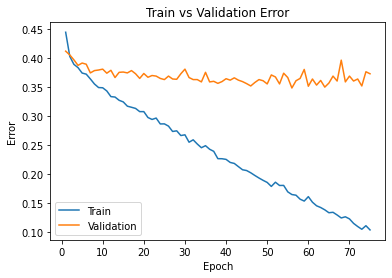

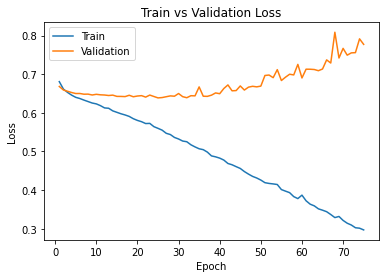

Files already downloaded and verified
Files already downloaded and verified
The error on the test set is:  0.375
The loss on the test set is:  0.788971558213234


In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
        self.name = "ANN"
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

ANN = ANN()
train_net(ANN, 256, 0.005, 75)
model_path_ANN = get_model_name("ANN", batch_size=256, learning_rate=0.005, epoch=74)
plot_training_curve(model_path_ANN)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size = 256)

test_err, test_loss = evaluate(ANN, test_loader, nn.BCEWithLogitsLoss())
print("The error on the test set is: ", test_err)
print("The loss on the test set is: ", test_loss)

The CNN has an error of 27.9% on the test set and a loss of 53.6% on the test set. Comparatively, the ANN has an error of 37.3% on the test set and a loss of 76.2% on the test set. Thus, the CNN gives us better results.